###  **Introduction**
## Drug Substitution Recommendation System  
**Objective**: Recommend safer drug alternatives based on adverse events, active ingredients, and safety warnings.  
**Data Sources**: openFDA API (/drug/ndc, /drug/label, /drug/event).  
**Techniques**: Supervised Learning, Clustering, Content-Based Filtering.  


### **Data Collection (API Fetching)**

In [3]:
import requests
import pandas as pd

# Function to fetch drugs from the NDC endpoint
def fetch_ndc_drugs(limit=500, pages=5):
    drug_list = []
    for page in range(pages):
        url = f"https://api.fda.gov/drug/ndc.json?limit={limit}&skip={page * limit}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get("results", [])
            drug_list.extend([item.get("brand_name", "").upper().strip() for item in data if "brand_name" in item])
    return list(set(drug_list))  # Remove duplicates

# Fetch a larger drug list
drug_list = fetch_ndc_drugs(limit=500, pages=5)
print(f"Total unique drugs fetched: {len(drug_list)}")

# Function to fetch NDC data
def fetch_ndc_data(drug_list):
    ndc_data = []
    for drug in drug_list:
        url = f"https://api.fda.gov/drug/ndc.json?search=brand_name:{drug}&limit=3"  # Increase limit for better coverage
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get("results", [])
            for item in data:
                ndc_data.append({
                    "drug_name": drug,
                    "product_ndc": item.get("product_ndc", "Not Available"),
                    "generic_name": item.get("generic_name", "Not Available"),
                    "dosage_form": item.get("dosage_form", "Not Available"),
                    "route": item.get("route", ["Not Available"])[0]  
                })
    return pd.DataFrame(ndc_data)

# Fetch a larger NDC dataset
ndc_df = fetch_ndc_data(drug_list)
print(f"Fetched {ndc_df.shape[0]} drug records from NDC dataset.")

# Function to fetch Label data
def fetch_label_data(drug_list):
    label_data = []
    for drug in drug_list:
        url = f"https://api.fda.gov/drug/label.json?search=brand_name:{drug}&limit=3"  # Increase limit
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get("results", [])
            for item in data:
                label_data.append({
                    "drug_name": drug,
                    "indications": item.get("indications_and_usage", "Not Available"),
                    "warnings": item.get("warnings", "Not Available")
                })
    return pd.DataFrame(label_data)

# Fetch data from Label dataset
label_df = fetch_label_data(drug_list)
print(f"Fetched {label_df.shape[0]} drug records from Label dataset.")

# Function data from Event data
def fetch_event_data(drug_list):
    event_data = []
    for drug in drug_list:
        url = f"https://api.fda.gov/drug/event.json?search=patient.drug.medicinalproduct:{drug}&limit=3"  # Increase limit
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json().get("results", [])
            for event in data:
                patient = event.get("patient", {})
                reactions = patient.get("reaction", [])
                for reaction in reactions:
                    event_data.append({
                        "drug_name": drug,
                        "reaction": reaction.get("reactionmeddrapt", "Not Available"),
                        "patient_age": patient.get("patientonsetage", "Not Available"),
                        "patient_sex": patient.get("patientsex", "Not Available")
                    })
    return pd.DataFrame(event_data)

# Fetch data from Event dataset
event_df = fetch_event_data(drug_list)
print(f"Fetched {event_df.shape[0]} drug records from Event dataset.")


Total unique drugs fetched: 1440
Fetched 4187 drug records from NDC dataset.
Fetched 3044 drug records from Label dataset.
Fetched 16883 drug records from Event dataset.


###   **Feature Engineering**

#### Merging all three datsets (Event Dataset, NDC Dataset, Label Dataset)

In [6]:

if "label_df" in globals() and "event_df" in globals() and "ndc_df" in globals():
    
    # Filter event_df and ndc_df to include only drug names present in label_df
    filtered_event_df = event_df[event_df["drug_name"].isin(label_df["drug_name"])]
    filtered_ndc_df = ndc_df[ndc_df["drug_name"].isin(label_df["drug_name"])]
    
    # Merge all three DataFrames on 'drug_name' using label_df as the reference
    merged_df = label_df.merge(filtered_event_df, on="drug_name", how="left").merge(filtered_ndc_df, on="drug_name", how="left")
    
    # Display the final merged DataFrame
    print(f"Final Merged DataFrame Shape: {merged_df.shape}")
    print(merged_df.head())  # Show first few rows
    
else:
    print("One or more DataFrames are still missing. Please reload the data.")


Final Merged DataFrame Shape: (105209, 10)
            drug_name                                        indications  \
0  CAREONE OMEPRAZOLE  [INDICATIONS AND USAGE Clarithromycin tablets ...   
1  CAREONE OMEPRAZOLE  [INDICATIONS AND USAGE Clarithromycin tablets ...   
2  CAREONE OMEPRAZOLE  [INDICATIONS AND USAGE Clarithromycin tablets ...   
3  CAREONE OMEPRAZOLE  [INDICATIONS AND USAGE Clarithromycin tablets ...   
4  CAREONE OMEPRAZOLE  [INDICATIONS AND USAGE Clarithromycin tablets ...   

                                            warnings  \
0  [WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...   
1  [WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...   
2  [WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...   
3  [WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...   
4  [WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...   

                                 reaction    patient_age patient_sex  \
0  Tuberculosis of central nervous system             59           2   
1  Tuberculosis of 

In [7]:
merged_df

,drug_name,indications,warnings,reaction,patient_age,patient_sex,product_ndc,generic_name,dosage_form,route
0,CAREONE OMEPRAZOLE,[INDICATIONS AND USAGE Clarithromycin tablets ...,[WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...,Tuberculosis of central nervous system,59,2,43598-010,Omeprazole and Sodium Bicarbonate,"POWDER, FOR SUSPENSION",ORAL
1,CAREONE OMEPRAZOLE,[INDICATIONS AND USAGE Clarithromycin tablets ...,[WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...,Tuberculosis of central nervous system,59,2,70700-149,Omeprazole,"CAPSULE, DELAYED RELEASE",ORAL
2,CAREONE OMEPRAZOLE,[INDICATIONS AND USAGE Clarithromycin tablets ...,[WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...,Tuberculosis of central nervous system,59,2,37000-455,omeprazole magnesium,"TABLET, DELAYED RELEASE",ORAL
3,CAREONE OMEPRAZOLE,[INDICATIONS AND USAGE Clarithromycin tablets ...,[WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...,Urticaria,Not Available,2,43598-010,Omeprazole and Sodium Bicarbonate,"POWDER, FOR SUSPENSION",ORAL
4,CAREONE OMEPRAZOLE,[INDICATIONS AND USAGE Clarithromycin tablets ...,[WARNINGS Use In Pregnancy CLARITHROMYCIN SHOU...,Urticaria,Not Available,2,70700-149,Omeprazole,"CAPSULE, DELAYED RELEASE",ORAL
...,...,...,...,...,...,...,...,...,...,...
105204,ANTI-BACTERIALHANDSPRAY SUN WASHED CITRUS,[Uses • helps prevent sunburn • higher SPF giv...,Not Available,Drug hypersensitivity,48,2,47335-907,Quetiapine fumarate,"TABLET, FILM COATED",ORAL
105205,ANTI-BACTERIALHANDSPRAY SUN WASHED CITRUS,[Uses • helps prevent sunburn • higher SPF giv...,Not Available,Drug hypersensitivity,48,2,62217-402,"Avobenzone, Homosalate, Octisalate, Octocrylen...",SPRAY,TOPICAL
105206,ANTI-BACTERIALHANDSPRAY SUN WASHED CITRUS,[Uses • helps prevent sunburn • higher SPF giv...,Not Available,Death,Not Available,1,14141-373,"OCTINOXATE, ZINC OXIDE",EMULSION,TOPICAL
105207,ANTI-BACTERIALHANDSPRAY SUN WASHED CITRUS,[Uses • helps prevent sunburn • higher SPF giv...,Not Available,Death,Not Available,1,47335-907,Quetiapine fumarate,"TABLET, FILM COATED",ORAL


In [8]:
print("\nMerged Data Info:")
print(merged_df.info())


Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105209 entries, 0 to 105208
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   drug_name     105209 non-null  object
 1   indications   105209 non-null  object
 2   warnings      105209 non-null  object
 3   reaction      105190 non-null  object
 4   patient_age   105190 non-null  object
 5   patient_sex   105190 non-null  object
 6   product_ndc   105209 non-null  object
 7   generic_name  105209 non-null  object
 8   dosage_form   105209 non-null  object
 9   route         105209 non-null  object
dtypes: object(10)
memory usage: 8.0+ MB
None


#### Handling Missing Values

In [10]:
print("\nMissing Values in Merged Data:\n", merged_df.isnull().sum())


Missing Values in Merged Data:
 drug_name        0
indications      0
warnings         0
reaction        19
patient_age     19
patient_sex     19
product_ndc      0
generic_name     0
dosage_form      0
route            0
dtype: int64


In [11]:
# Drop rows where patient_sex is null
merged_df = merged_df.dropna(subset=["patient_sex"])


In [12]:
import numpy as np

# Ensure patient_age is numeric and replace "Not Available" with NaN
merged_df["patient_age"] = pd.to_numeric(merged_df["patient_age"], errors="coerce")

# Fill missing patient_age with the median value based on patient_sex
merged_df["patient_age"] = merged_df.groupby("patient_sex")["patient_age"].transform(lambda x: x.fillna(x.median()))


/var/folders/7w/gzzfcxzs57qdgyj1vvhchl3w0000gn/T/ipykernel_89338/3119487141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["patient_age"] = pd.to_numeric(merged_df["patient_age"], errors="coerce")
/var/folders/7w/gzzfcxzs57qdgyj1vvhchl3w0000gn/T/ipykernel_89338/3119487141.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["patient_age"] = merged_df.groupby("patient_sex")["patient_age"].transform(lambda x: x.fillna(x.median()))


In [13]:
# Fill any remaining NaN values with the overall median of patient_age
merged_df.loc[:, "patient_age"] = merged_df["patient_age"].fillna(merged_df["patient_age"].median())

In [14]:
print("\nMissing Values in Merged Data:\n", merged_df.isnull().sum())


Missing Values in Merged Data:
 drug_name       0
indications     0
warnings        0
reaction        0
patient_age     0
patient_sex     0
product_ndc     0
generic_name    0
dosage_form     0
route           0
dtype: int64


In [15]:
# List of columns to check for "Not Available" values
columns_to_check = ["route", "dosage_form"]

# Count occurrences of "Not Available" in each column
not_available_counts = (merged_df[columns_to_check] == "Not Available").sum()

not_available_counts

route          8496
dosage_form       0
dtype: int64

In [16]:
# Define the mapping of dosage_form to route
dosage_to_route_mapping = {
    "TABLET": "ORAL",
    "CAPSULE": "ORAL",
    "INJECTION": "INTRAVENOUS",
    "CREAM": "TOPICAL",
    "OINTMENT": "TOPICAL",
    "GEL": "TOPICAL",
    "PATCH": "TRANSDERMAL",
    "LIQUID": "ORAL",
    "SOLUTION": "INTRAVENOUS",
    "SPRAY": "NASAL",
    "DROPS": "OPHTHALMIC",
    "SUPPOSITORY": "RECTAL"
}

# Fill "Not Available" in route based on dosage_form
merged_df.loc[merged_df["route"] == "Not Available", "route"] = (
    merged_df["dosage_form"].map(dosage_to_route_mapping).fillna("Unknown")
)

# Verify if "Not Available" values in route are filled
print("Count of 'Not Available' in route after filling:", (merged_df["route"] == "Not Available").sum())


Count of 'Not Available' in route after filling: 0


#### Encoding Categorical Variables

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

label_encoder = LabelEncoder()
merged_df.loc[:, "drug_encoded"] = label_encoder.fit_transform(merged_df["drug_name"])


/var/folders/7w/gzzfcxzs57qdgyj1vvhchl3w0000gn/T/ipykernel_89338/2476279588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.loc[:, "drug_encoded"] = label_encoder.fit_transform(merged_df["drug_name"])


#### One-hot encoding for categorical features


In [20]:

encoded_cols = pd.get_dummies(merged_df[["route", "patient_sex"]], drop_first=True)
merged_df = pd.concat([merged_df, encoded_cols], axis=1)
merged_df.drop(["route", "patient_sex"], axis=1, inplace=True)


#### Extracting Warning Severity (Word Count)

In [22]:
merged_df["warning_length"] = merged_df["warnings"].apply(lambda x: len(str(x).split()))

#### Extracting Most Common Adverse Reactions

In [24]:
top_reactions = merged_df["reaction"].value_counts().index[:10].tolist()
for reaction in top_reactions:
    merged_df[f"reaction_{reaction}"] = merged_df["reaction"].apply(lambda x: 1 if x == reaction else 0)



#### Drug Risk Score Calculation

In [26]:
high_risk_words = ["fatal", "severe", "hospitalization", "life-threatening", "emergency", "death"]
def calculate_risk_score(warning_text):
    return sum(1 for word in high_risk_words if word in str(warning_text).lower())

merged_df["risk_score"] = merged_df["warnings"].apply(calculate_risk_score)


#### Scaling Numerical Features


In [28]:
scaler = StandardScaler()
merged_df[["patient_age", "risk_score"]] = scaler.fit_transform(merged_df[["patient_age", "risk_score"]])


#### Clustering for Drug Similarity (Unsupervised Learning)

In [30]:
from sklearn.cluster import KMeans

# Selecting features for clustering
clustering_features = ["risk_score", "warning_length"] + [col for col in merged_df.columns if col.startswith("reaction_")]


In [31]:
# Applying K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
merged_df["cluster"] = kmeans.fit_predict(merged_df[clustering_features])


#### Content-Based Filtering - Finding Similar Drugs

In [33]:
### **K-Nearest Neighbors (KNN) for Finding Similar Drugs**
from sklearn.neighbors import NearestNeighbors

# Convert relevant features to a NumPy array
feature_matrix = merged_df[["risk_score", "warning_length"]].values

# Use Nearest Neighbors instead of computing the full similarity matrix
nbrs = NearestNeighbors(n_neighbors=6, metric="euclidean").fit(feature_matrix)

# Function to recommend similar drugs efficiently
def recommend_drug(drug_name, n=5):
    index = merged_df[merged_df["drug_name"] == drug_name].index[0]
    
    # Find nearest neighbors
    distances, indices = nbrs.kneighbors([feature_matrix[index]])
    
    # Exclude the original drug and get top recommendations
    recommended_drugs = merged_df.iloc[indices[0][1:n+1]]["drug_name"].tolist()
    
    return recommended_drugs

# Test optimized recommendation system
print(recommend_drug("NORTRIPTYLINE HYDROCHLORIDE", n=5))

['MECLIZINE HYDROCHLORIDE', 'MECLIZINE HYDROCHLORIDE', 'MECLIZINE HYDROCHLORIDE', 'MECLIZINE HYDROCHLORIDE', 'MECLIZINE HYDROCHLORIDE']


#### Data Ready for Model Training*

In [35]:
final_features = [
    "drug_encoded", "patient_age", "warning_length", "risk_score"
] + [col for col in merged_df.columns if col.startswith("reaction_")]

# Creating final dataset
final_df = merged_df[final_features]


In [36]:
final_df

,drug_encoded,patient_age,warning_length,risk_score,reaction_Drug hypersensitivity,reaction_Dyspepsia,reaction_Renal impairment,reaction_Abdominal pain,reaction_Diarrhoea,reaction_Pyrexia,reaction_Asthenia,reaction_Back pain,reaction_Tuberculosis of central nervous system,reaction_Nausea
0,179,-0.032257,839,2.613133,0,0,0,0,0,0,0,0,1,0
1,179,-0.032257,839,2.613133,0,0,0,0,0,0,0,0,1,0
2,179,-0.032257,839,2.613133,0,0,0,0,0,0,0,0,1,0
3,179,-0.029067,839,2.613133,0,0,0,0,0,0,0,0,0,0
4,179,-0.029067,839,2.613133,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105204,66,-0.049805,2,-0.497984,1,0,0,0,0,0,0,0,0,0
105205,66,-0.049805,2,-0.497984,1,0,0,0,0,0,0,0,0,0
105206,66,-0.025876,2,-0.497984,0,0,0,0,0,0,0,0,0,0
105207,66,-0.025876,2,-0.497984,0,0,0,0,0,0,0,0,0,0


### Visualizations 


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure merged_df exists
if 'merged_df' not in globals():
    raise ValueError("Dataset 'merged_df' is not available. Please load it before running this script.")


sns.set_style("whitegrid")


 #### 1. Analyze Adverse Reactions: Frequency of different drug reactions

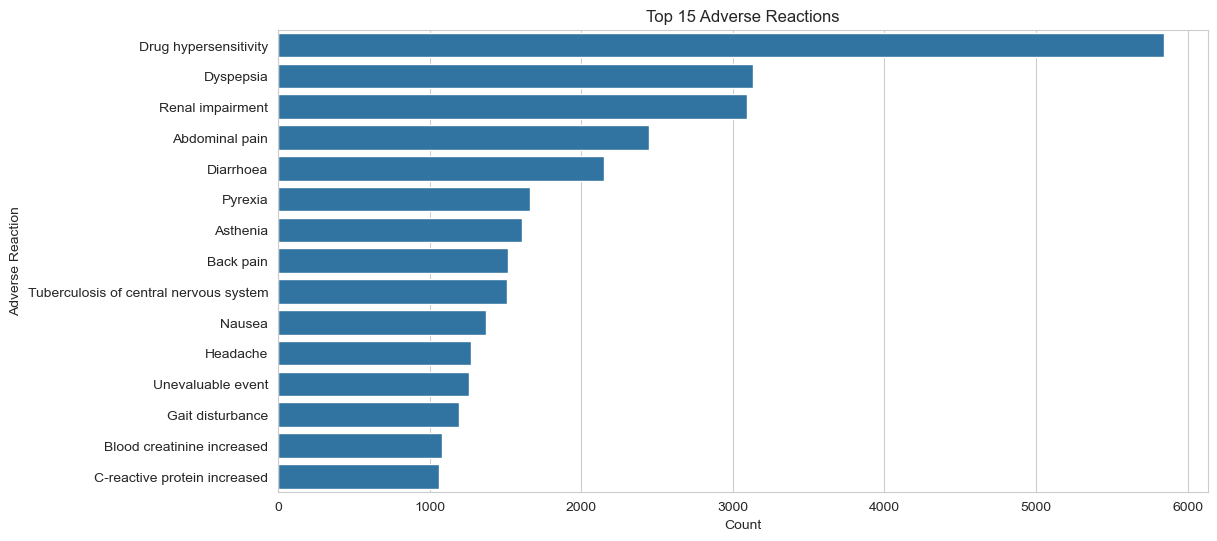

In [40]:
plt.figure(figsize=(12, 6))
reaction_counts = merged_df["reaction"].value_counts().nlargest(15)  # Top 15 reactions
sns.barplot(x=reaction_counts.values, y=reaction_counts.index)
plt.xlabel("Count")
plt.ylabel("Adverse Reaction")
plt.title("Top 15 Adverse Reactions")
plt.show()

Visualizes the frequency of reported adverse reactions to identify the most common side effects.

#### 2. Explore Drug Warnings: Distribution of warning lengths

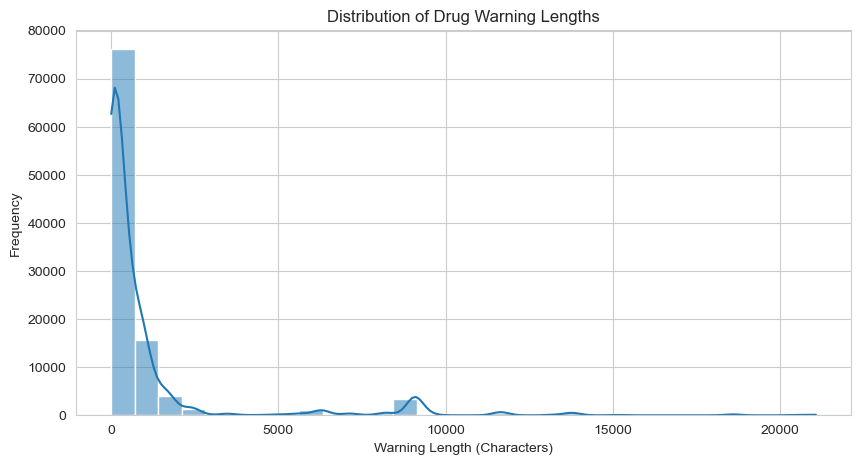

In [42]:

merged_df["warning_length"] = merged_df["warnings"].astype(str).apply(len)  # Convert warnings to length
plt.figure(figsize=(10, 5))
sns.histplot(merged_df["warning_length"], bins=30, kde=True)
plt.xlabel("Warning Length (Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Drug Warning Lengths")
plt.show()

Shows the distribution of the number of characters in drug warnings, highlighting variations in warning detail.

#### 3. Risk Score Analysis: Distribution and correlation with adverse events

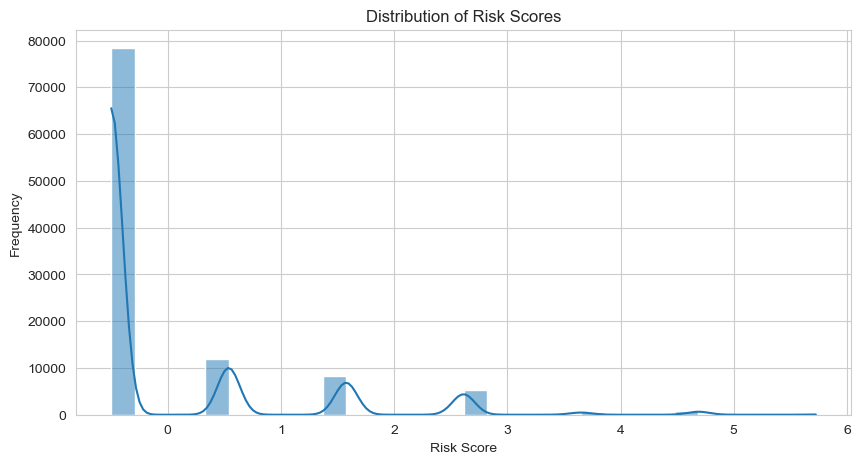

In [44]:

plt.figure(figsize=(10, 5))
sns.histplot(merged_df["risk_score"], bins=30, kde=True)
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.title("Distribution of Risk Scores")
plt.show()

Examines the distribution of risk scores derived from warnings and their correlation with reported adverse events.

#### 4.Scatter plot for risk score vs. adverse events (reaction count per drug)

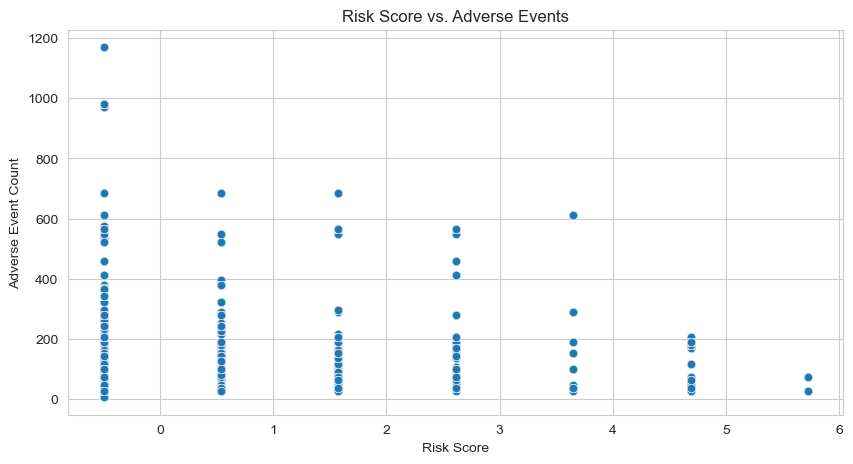

In [46]:

plt.figure(figsize=(10, 5))
merged_df["reaction_count"] = merged_df.groupby("drug_name")["reaction"].transform("count")
sns.scatterplot(x=merged_df["risk_score"], y=merged_df["reaction_count"], alpha=0.5)
plt.xlabel("Risk Score")
plt.ylabel("Adverse Event Count")
plt.title("Risk Score vs. Adverse Events")
plt.show()


Displays the relationship between risk scores and the number of adverse reactions per drug.

#### 5. Patient Demographics: Age Distributions

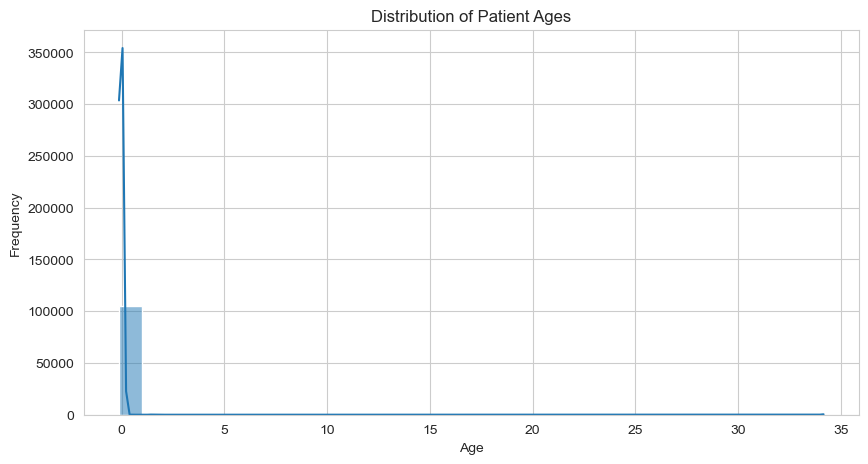

In [48]:

plt.figure(figsize=(10, 5))
sns.histplot(merged_df["patient_age"].dropna(), bins=30, kde=True)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of Patient Ages")
plt.show()


Highlights the age groups most commonly affected by adverse drug reactions.

    #### 6. Feature Relationships: Correlation Heatmap

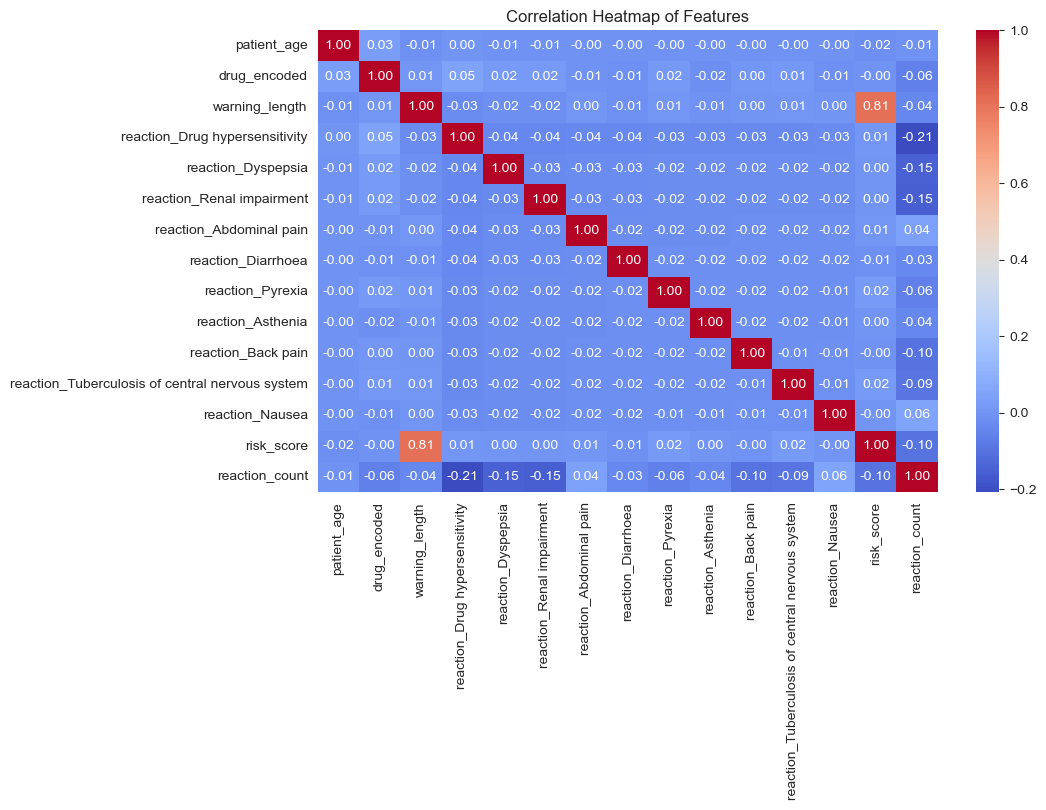

In [50]:

numeric_features = merged_df.select_dtypes(include=["float64", "int64"]).drop(columns=["patient_sex"], errors="ignore")
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

A heatmap showing correlations between numerical features like age, risk scores, and reaction frequency.

 #### 7.Distribution of Dosage Forms

/var/folders/7w/gzzfcxzs57qdgyj1vvhchl3w0000gn/T/ipykernel_89338/4195364363.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=merged_df["dosage_form"], order=merged_df["dosage_form"].value_counts().index, palette="coolwarm")


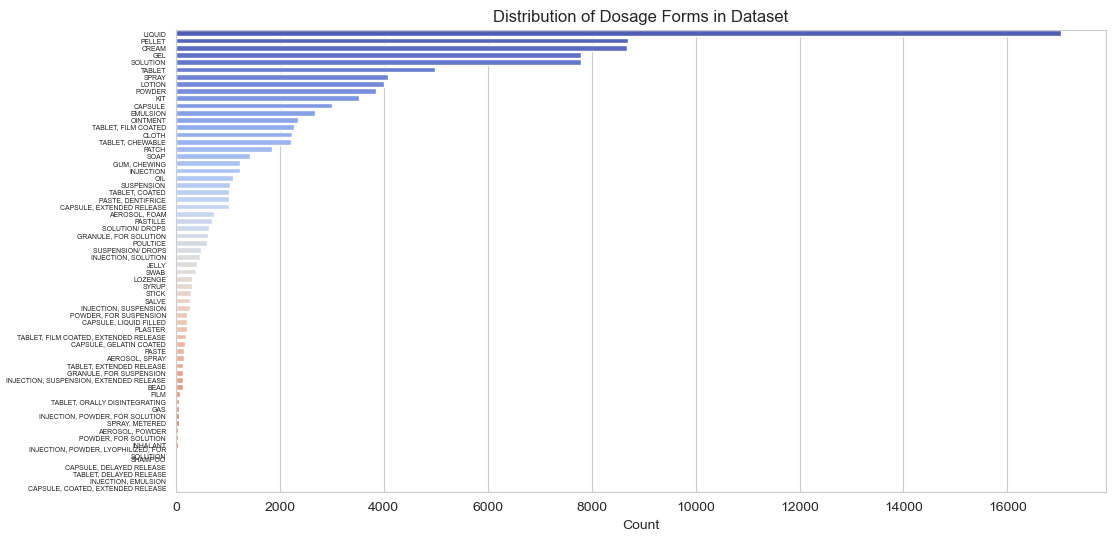

In [106]:
plt.figure(figsize=(12, 6))
sns.countplot(y=merged_df["dosage_form"], order=merged_df["dosage_form"].value_counts().index, palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Dosage Form")
plt.title("Distribution of Dosage Forms in Dataset")
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=5, wrap=True)
plt.show()

This count plot shows the frequency of different dosage forms (e.g., tablets, injections), helping analyze the most common drug delivery methods.

#### 8.Relationship Between Patient Age and Risk Score

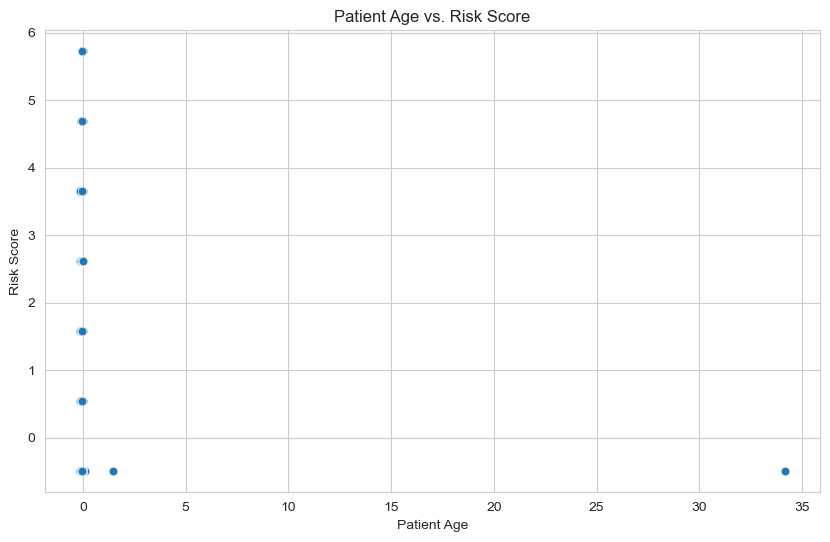

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df["patient_age"], y=merged_df["risk_score"], alpha=0.5)
plt.xlabel("Patient Age")
plt.ylabel("Risk Score")
plt.title("Patient Age vs. Risk Score")
plt.show()


This scatter plot explores how drug risk scores vary across different patient ages, helping analyze potential risk patterns in different age groups.



#### 9.Top 10 Drugs with Most Adverse Events

/var/folders/7w/gzzfcxzs57qdgyj1vvhchl3w0000gn/T/ipykernel_89338/3875399370.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_drugs.values, y=top_drugs.index, palette="coolwarm")


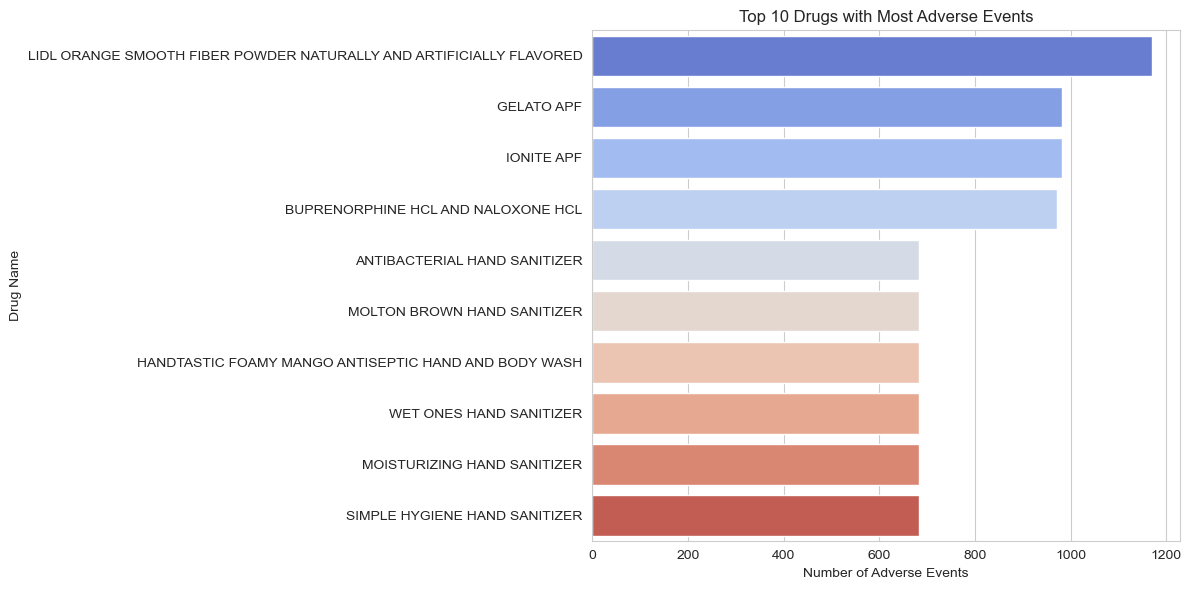

In [112]:
plt.figure(figsize=(12, 6))
top_drugs = merged_df["drug_name"].value_counts().head(10)
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette="coolwarm")
plt.xlabel("Number of Adverse Events")
plt.ylabel("Drug Name")
plt.title("Top 10 Drugs with Most Adverse Events")
plt.tight_layout()
plt.show()


This bar chart shows the top 10 drugs associated with the highest number of adverse events in the dataset. It highlights drugs with significant risks based on frequency.

#### 10.Scatter Plot: Risk Score vs Warning Length (Hue = Patient Age)

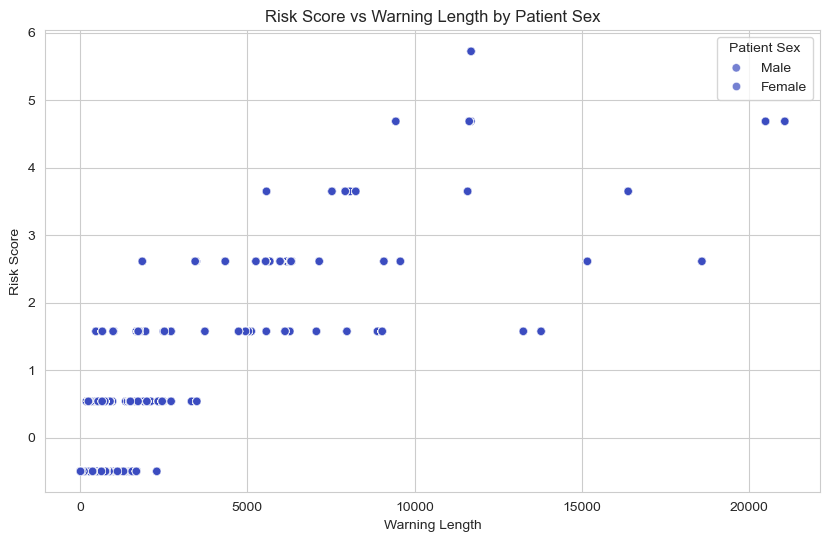

In [126]:
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x=merged_df["warning_length"],
    y=merged_df["risk_score"],
    hue=merged_df["patient_age"],
    palette="viridis",
    alpha=0.7
)
plt.xlabel("Warning Length")
plt.ylabel("Risk Score")
plt.title("Risk Score vs Warning Length by Patient Age")
plt.colorbar(scatter.collections[0].colorbar, label="Patient Age")
plt.show()


Explores the relationship between risk scores and warning lengths while factoring in patient age as a hue.